# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
import numpy as np
import os
from imageio import imread
from skimage.transform import resize
import datetime
import os

We set the random seed so that the results don't vary drastically.

In [3]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [4]:
train_doc = np.random.permutation(open('datasets/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('datasets/Project_data/val.csv').readlines())
batch_size = 32
img_height = 100
img_width = 100

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [5]:
img_idx = [1,2,4,6,8,10,12,14,25,26,27,28,29]
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    while True:
        t = np.random.permutation(folder_list)
        num_batches = int(len(t)/batch_size)
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,len(img_idx),img_height,img_width,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

                    image_croped=resize(image,(img_height,img_width,3))

                    batch_data[folder,idx,:,:,0] = (image_croped[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image_croped[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image_croped[:,:,2])/255

                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do


        # write the code for the remaining data points which are left after full batches
        if(len(t)%batch_size):
          unread_img_cnt = len(t)%batch_size
          batch_data = np.zeros((unread_img_cnt,len(img_idx),img_height,img_width,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
          batch_labels = np.zeros((unread_img_cnt,5)) # batch_labels is the one hot representation of the output
          for folder in range(unread_img_cnt): # iterate over the batch_size
              imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0]) # read all the images in the folder
              for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                  image = imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

                  image_croped=resize(image,(img_height,img_width,3))

                  batch_data[folder,idx,:,:,0] = (image_croped[:,:,0])/255
                  batch_data[folder,idx,:,:,1] = (image_croped[:,:,1])/255
                  batch_data[folder,idx,:,:,2] = (image_croped[:,:,2])/255

              batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1
          yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [6]:
curr_dt_time = datetime.datetime.now()
train_path = 'datasets/Project_data/train'
val_path = 'datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 30 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 30


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [7]:
device_name = tf.test.gpu_device_name()
print (device_name)

/device:GPU:0


2024-03-06 15:58:26.043104: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2024-03-06 15:58:26.043161: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:0 with 22849 MB memory:  -> device: 0, name: Quadro RTX 6000, pci bus id: 0000:1e:00.0, compute capability: 7.5


In [8]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers import Conv2D, Conv3D, MaxPooling2D, MaxPooling3D, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

In [9]:

with tf.device(device_name):
  model = Sequential()
  model.add(TimeDistributed(
      Conv2D(32, (3,3), activation='relu'), input_shape=(len(img_idx),100,100,3))
  )
  model.add(TimeDistributed(
      MaxPooling2D((2,2)))
  )
  model.add(BatchNormalization())

  model.add(TimeDistributed(
      Conv2D(64, (3,3), activation='relu'))
  )
  model.add(TimeDistributed(
      MaxPooling2D((2,2)))
  )
  model.add(BatchNormalization())

  model.add(TimeDistributed(GlobalAveragePooling2D()))
  model.add(TimeDistributed(Dense(64, activation='relu')))
  model.add(BatchNormalization())

  model.add(GRU(128))
  model.add(BatchNormalization())
  model.add(Dense(5, activation='softmax'))

2024-03-06 15:58:26.077560: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22849 MB memory:  -> device: 0, name: Quadro RTX 6000, pci bus id: 0000:1e:00.0, compute capability: 7.5


In [10]:
# with tf.device(device_name):
#   model = Sequential()
#   model.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=(len(img_idx),100,100,3)))
#   model.add(MaxPooling3D(pool_size=2))

#   model.add(Conv3D(64, kernel_size=3, activation='relu'))
#   model.add(MaxPooling3D(pool_size=2))

#   model.add(Flatten())
#   model.add(Dense(256, activation='relu'))
#   model.add(Dense(5, activation='softmax'))

In [11]:
# with tf.device(device_name):

#     model = Sequential()

#     model.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=(len(img_idx),100,100,3)))
#     model.add(Conv3D(64, kernel_size=3, activation='relu'))
#     model.add(MaxPooling3D(pool_size=(2, 2, 2)))

#     model.add(Conv3D(64, kernel_size=3, activation='relu'))
#     model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(1, 1, 1), padding='same'))

#     model.add(Conv3D(256, kernel_size=(3, 3, 3), activation='relu', padding='same'))
#     model.add(MaxPooling3D(pool_size=(3, 2, 2), strides=(2, 2, 2), padding='same'))
#     model.add(Conv3D(512, kernel_size=(3, 3, 3), activation='relu', padding='same'))
#     model.add(Flatten())
#     model.add(Dense(512, activation='relu'))
#     model.add(Dense(5, activation='softmax'))

In [12]:
# with tf.device(device_name):
#     model = Sequential()
#     model.add(TimeDistributed(
#         Conv2D(8, (3,3), activation='relu'), input_shape=(len(img_idx),100,100,3))
#     )
#     model.add(BatchNormalization())
#     model.add(TimeDistributed(
#         Conv2D(16, (3,3), activation='relu'))
#     )
#     model.add(BatchNormalization())
#     model.add(
#         ConvLSTM2D(8, kernel_size = 3, return_sequences=False)
#     )
#     model.add(BatchNormalization())
#     model.add(TimeDistributed(
#         Dense(64, activation='relu'))
#     )
#     model.add(BatchNormalization())
#     model.add(GlobalAveragePooling2D())
#     model.add(Dense(64, activation='relu'))
#     model.add(Dense(5, activation='softmax'))

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [13]:
with tf.device(device_name):
  optimiser = 'adam' #write your optimizer
  model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
  print (model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 13, 98, 98, 32)   896       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 13, 49, 49, 32)   0         
 tributed)                                                       
                                                                 
 batch_normalization (BatchN  (None, 13, 49, 49, 32)   128       
 ormalization)                                                   
                                                                 
 time_distributed_2 (TimeDis  (None, 13, 47, 47, 64)   18496     
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 13, 23, 23, 64)   0

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [14]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [15]:
def model_callbacks(folder_name):
    model_name = str(folder_name) + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

    if not os.path.exists(model_name):
        os.mkdir(model_name)

    filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

    LR = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=0.0001, cooldown=1, verbose=1) # write the REducelronplateau code here

    return [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [16]:
callbacks_list = model_callbacks("model_2D")

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [17]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  datasets/Project_data/train ; batch size = 32


/tmp/ipykernel_783/2585147562.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Epoch 1/30


2024-03-06 15:58:34.709186: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


21/21 [==============================] - ETA: 0s - loss: 1.3068 - categorical_accuracy: 0.4781Source path =  datasets/Project_data/val ; batch size = 32

Epoch 00001: val_loss improved from inf to 1.60204, saving model to model_2D_2024-03-0615_58_25.241986/model-00001-1.30676-0.47813-1.60204-0.18000.h5
21/21 [==============================] - 134s 6s/step - loss: 1.3068 - categorical_accuracy: 0.4781 - val_loss: 1.6020 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 2/30
21/21 [==============================] - ETA: 0s - loss: 1.0348 - categorical_accuracy: 0.5611
Epoch 00002: val_loss improved from 1.60204 to 1.59793, saving model to model_2D_2024-03-0615_58_25.241986/model-00002-1.03479-0.56109-1.59793-0.31000.h5
21/21 [==============================] - 130s 7s/step - loss: 1.0348 - categorical_accuracy: 0.5611 - val_loss: 1.5979 - val_categorical_accuracy: 0.3100 - lr: 0.0010
Epoch 3/30
21/21 [==============================] - ETA: 0s - loss: 0.8218 - categorical_accuracy: 0.6

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


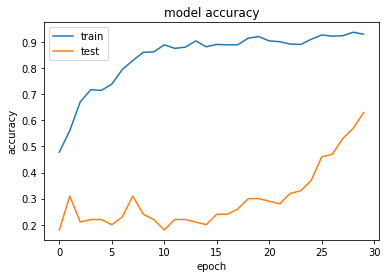

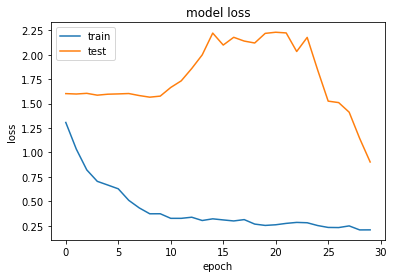

In [18]:
import matplotlib.pyplot as plt
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()